# Task 1

## Imports

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import kagglehub
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense

import transformers as ppb
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Task 2

### Part 1

I am choosing to use the BERT model:



1. Word2Vec

  * Unlike BERT, Word2Vec provides a single context-independent embedding vector for each word. This means that the same word is not able to have different vectors based on its meanings in Word2Vec. As a result, Word2Vec has trouble with meaning of word based on context. BERT is also able to handle unknown words, whereas Word2Vec is not able to handle unknown words.


2. GloVe
  * Unlike BERT, GloVE has static embeddings, meaning that it doesn't adapt to context. As a result, GloVe has a harder time understanding the meaning of the sentence, as some words have different meanings depending on the context of the sentence. GloVe also is not able to handle unknown words.

3. FastText
  *   Similar to GloVe, FastText has static embeddings, meaning it is hard for the model to understand some sentences, as some words may have different meanings depending on the context.


Because BERT is able to provide contextual embeddings, and is able to deal with unknown words, I have chosen to use BERT.



In [ ]:
# Loading BERT model
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def get_embedding(word):
  # Tokenize word
  tokens = tokenizer.tokenize(word)
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  input_ids = torch.tensor([token_ids])

  # Get hidden states from BERT
  with torch.no_grad():
      outputs = model(input_ids)
      hidden_states = outputs.last_hidden_state

  # Average embeddings of subword tokens
  word_embedding = hidden_states[0].mean(dim=0)

  return word_embedding, tokens

In [ ]:
word1 = input("Enter the first word: ").strip().lower()
word2 = input("Enter the second word: ").strip().lower()

embedding1, tokens_word1 = get_embedding(word1)
embedding2, tokens_word2 = get_embedding(word2)

print(f"\nWord: '{word1}'\nTokens: {tokens_word1}")
print(f"First 10 values of embedding with shape {embedding1.shape}): {embedding1[:10]}")
print()
print(f"Word: '{word2}'\nTokens: {tokens_word2}")
print(f"First 10 values of embedding with shape {embedding2.shape}): {embedding2[:10]}")


Enter the first word: Hello
Enter the second word: Bye

Word: 'hello'
Tokens: ['hello']
First 10 values of embedding with shape torch.Size([768])): tensor([ 0.3216,  0.5476,  0.2767, -0.3427,  0.2947, -0.1897, -0.1436, -0.1618,
         0.2762, -0.4210])

Word: 'bye'
Tokens: ['bye']
First 10 values of embedding with shape torch.Size([768])): tensor([-0.0588,  0.1226,  0.2399, -0.2145,  0.3791, -0.0053,  0.0883, -0.0917,
         0.2446, -0.3711])


BERT automatically deals with OOV by splitting unknown words into known subwords using WordPiece tokenization.

### Part 2

In [ ]:
def cosine_similarity(embedding1, embedding2):
  # Make sure that both embedding vectors are 1D tensors
  embedding1 = embedding1.squeeze()
  embedding2 = embedding2.squeeze()

  # Find the magnitudes of each embedding vector
  norm1 = torch.norm(embedding1)
  norm2 = torch.norm(embedding2)

  # Cosine similarity (dot product of the two embeddings / the norms multiplied)
  similarity = torch.dot(embedding1, embedding2) / (norm1 * norm2)

  return similarity.item()

In [ ]:
def batch_processing(pairs):
  similarities = []

  # finds the cosine similarities for each pair of words in the pairs list
  for word1, word2 in pairs:
    emb1 = get_embedding(word1)[0]
    emb2 = get_embedding(word2)[0]

    cos_sim = cosine_similarity(emb1, emb2)
    similarities.append((word1, word2, cos_sim))
  return similarities


In [ ]:
batch_input = [[word1, word2],
                ["Hi", "Bye"]]

results = batch_processing(batch_input)

for w1, w2, similarity in results:
  print(f"Cosine similarity between '{w1}' and '{w2}': {similarity:.4f}")


Cosine similarity between 'hello' and 'bye': 0.3571
Cosine similarity between 'Hi' and 'Bye': 0.2676


Cosine Similarity is useful in word embedding spaces, because it is able to capture the semantic relationships between words. It does this by focusing on the direction between the two vector representations, instead of focusing on their magnitudes. As a result, Cosine Similarity allows us to identify words with similar meanings, even if the words have different frequencies or different contexts.

In [ ]:
def visualize_embeddings(words):
  embeddings = []

  for word in words:
    # Get the BERT embedding
    embedding_tensor = get_embedding(word)[0]
    # Convert to embedding to NumPy
    embedding_np = embedding_tensor.detach().numpy()
    embeddings.append(embedding_np)

  pca = PCA(n_components=2)
  reduced = pca.fit_transform(embeddings)

  # Plot
  plt.figure(figsize=(8, 6))
  sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1])

  for i, word in enumerate(words):
    plt.text(reduced[i, 0] + 0.01, reduced[i, 1] + 0.01, word)

  plt.title('PCA Visualization of Word Embeddings')
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.grid(True)
  plt.show()


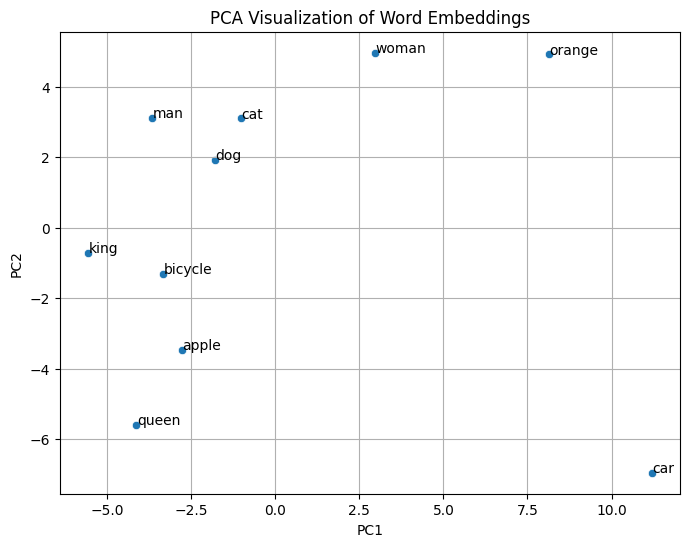

In [ ]:
visualize_inputs = ["king", "queen", "man", "woman", "apple", "orange", "car", "bicycle", "dog", "cat"]

visualize_embeddings(visualize_inputs)

### Part 3

In [ ]:
def euclidean_dissimilarity(embedding1, embedding2):
  # Makes sure embeddings are 1D tensors
  embedding1 = embedding1.squeeze()
  embedding2 = embedding2.squeeze()

  # Euclidean distance
  distance = torch.norm(embedding1 - embedding2, p=2)

  return distance.item()

Euclidean distance measures the absolute distance between two word embeddings in vector space. This helps quantify how far apart the semantic representations of two words are. While cosine similarity focuses solely on the direction of vectors, Euclidean distance accounts for both direction and magnitude. As a result, it is better suited for capturing semantic diversity, as it can reveal differences not just in meaning, but also in how distinctly the words are represented in the embedding space.

In [ ]:
def similarity_dissimilarity(run_cosine, embedding1, embedding2):
  if run_cosine:
    val = f"Cosine Similarity: {cosine_similarity(embedding1, embedding2):.4f}"
    return val
  else:
    val = f"Euclidean Dissimilarity: {euclidean_dissimilarity(embedding1, embedding2):.4f}"
    return val

print(similarity_dissimilarity(True, get_embedding("bye")[0], get_embedding("hi")[0]))
print(similarity_dissimilarity(False, get_embedding("bye")[0], get_embedding("hi")[0]))

Cosine Similarity: 0.2676
Euclidean Dissimilarity: 16.0256


#### Visualizations

In [ ]:
def compute_matrix(words, method='cosine'):
  # Stores the values for the similarity and dissimilarities
  n = len(words)
  matrix = np.zeros((n, n))

  # fills up matrix with similarity or dissimilarity values
  for i in range(n):
    for j in range(n):
      # get the word embeddings for the ith and jth words
      emb1 = get_embedding(words[i])[0]
      emb2 = get_embedding(words[j])[0]

      if method == 'cosine':
        value = cosine_similarity(emb1, emb2)
      elif method == 'euclidean':
        value = euclidean_dissimilarity(emb1, emb2)

      matrix[i, j] = value

  return pd.DataFrame(matrix, index=words, columns=words)


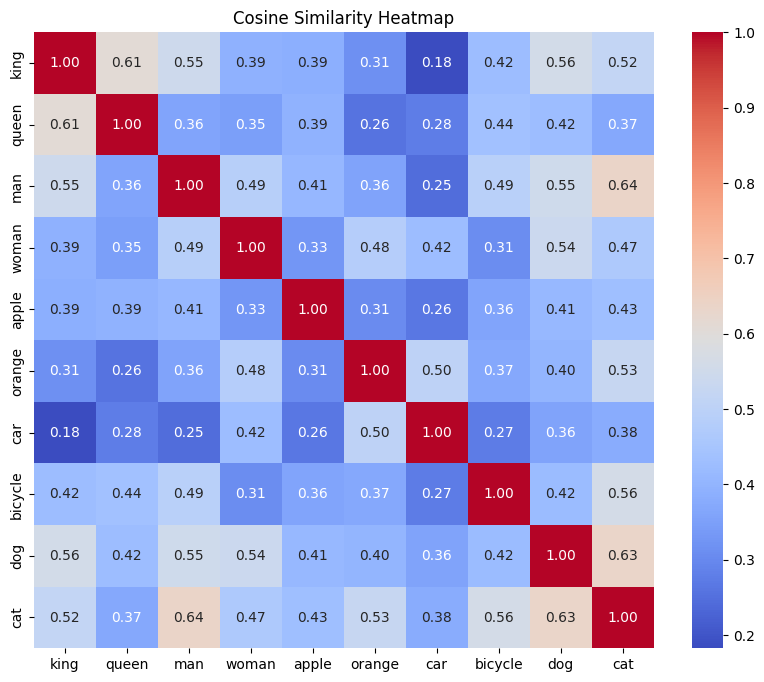

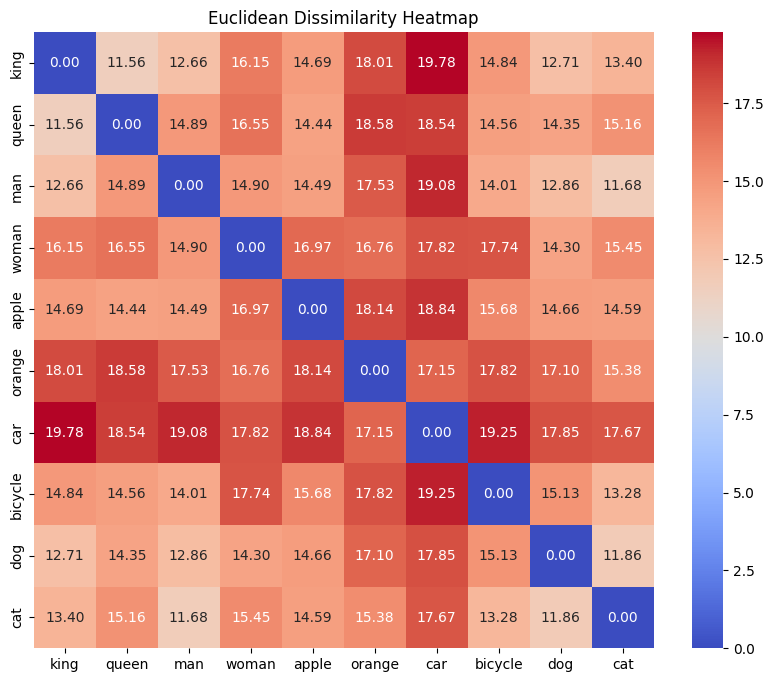

In [ ]:
# Compute matrices
cosine_df = compute_matrix(visualize_inputs, method='cosine')
euclidean_df = compute_matrix(visualize_inputs, method='euclidean')

plt.figure(figsize=(10, 8))
sns.heatmap(cosine_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Cosine Similarity Heatmap")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(euclidean_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Euclidean Dissimilarity Heatmap")
plt.show()